In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dogs-vs-cats/test1.zip
/kaggle/input/dogs-vs-cats/train.zip
/kaggle/input/dogs-vs-cats/sampleSubmission.csv


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from tqdm import tqdm
import plotly.express as px
import random
from PIL import Image
import plotly.graph_objects as go
import zipfile

In [3]:
with zipfile.ZipFile('/kaggle/input/dogs-vs-cats/train.zip', 'r') as zip_ref:
    zip_ref.extractall('/kaggle/working/train')
with zipfile.ZipFile('/kaggle/input/dogs-vs-cats/test1.zip', 'r') as zip_ref:
    zip_ref.extractall('/kaggle/working/test')

In [4]:
train_dir = '/kaggle/working/train/train'
test_dir = '/kaggle/working/test/test1'

# **load and preprocess the images**

In [5]:
def load_images(folder, img_size=(64, 64), sample_count=20, label_filter=None):
    images = []
    labels = []
    filenames = os.listdir(folder)

    if label_filter is not None:
        filenames = [fname for fname in filenames if label_filter in fname]

    random.shuffle(filenames)
    for img in filenames[:sample_count]:
        try:
            img_path = os.path.join(folder, img)
            img_pil = Image.open(img_path)
            img_pil = img_pil.resize(img_size)
            img_np = np.array(img_pil) / 255.0
            images.append(img_np)
            labels.append(0 if 'cat' in img else 1)
        except Exception as e:
            print(f"Error loading image {img}: {e}")

    return np.array(images), np.array(labels)

***labeling images***

In [6]:
def visualize_images(images, labels, sample_count=20):
    fig, axes = plt.subplots(4, 5, figsize=(15, 12))
    axes = axes.flatten()

    for i in range(sample_count):
        axes[i].imshow(images[i])
        axes[i].set_title('Cat' if labels[i] == 0 else 'Dog')
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

***Load and visualize cat images***

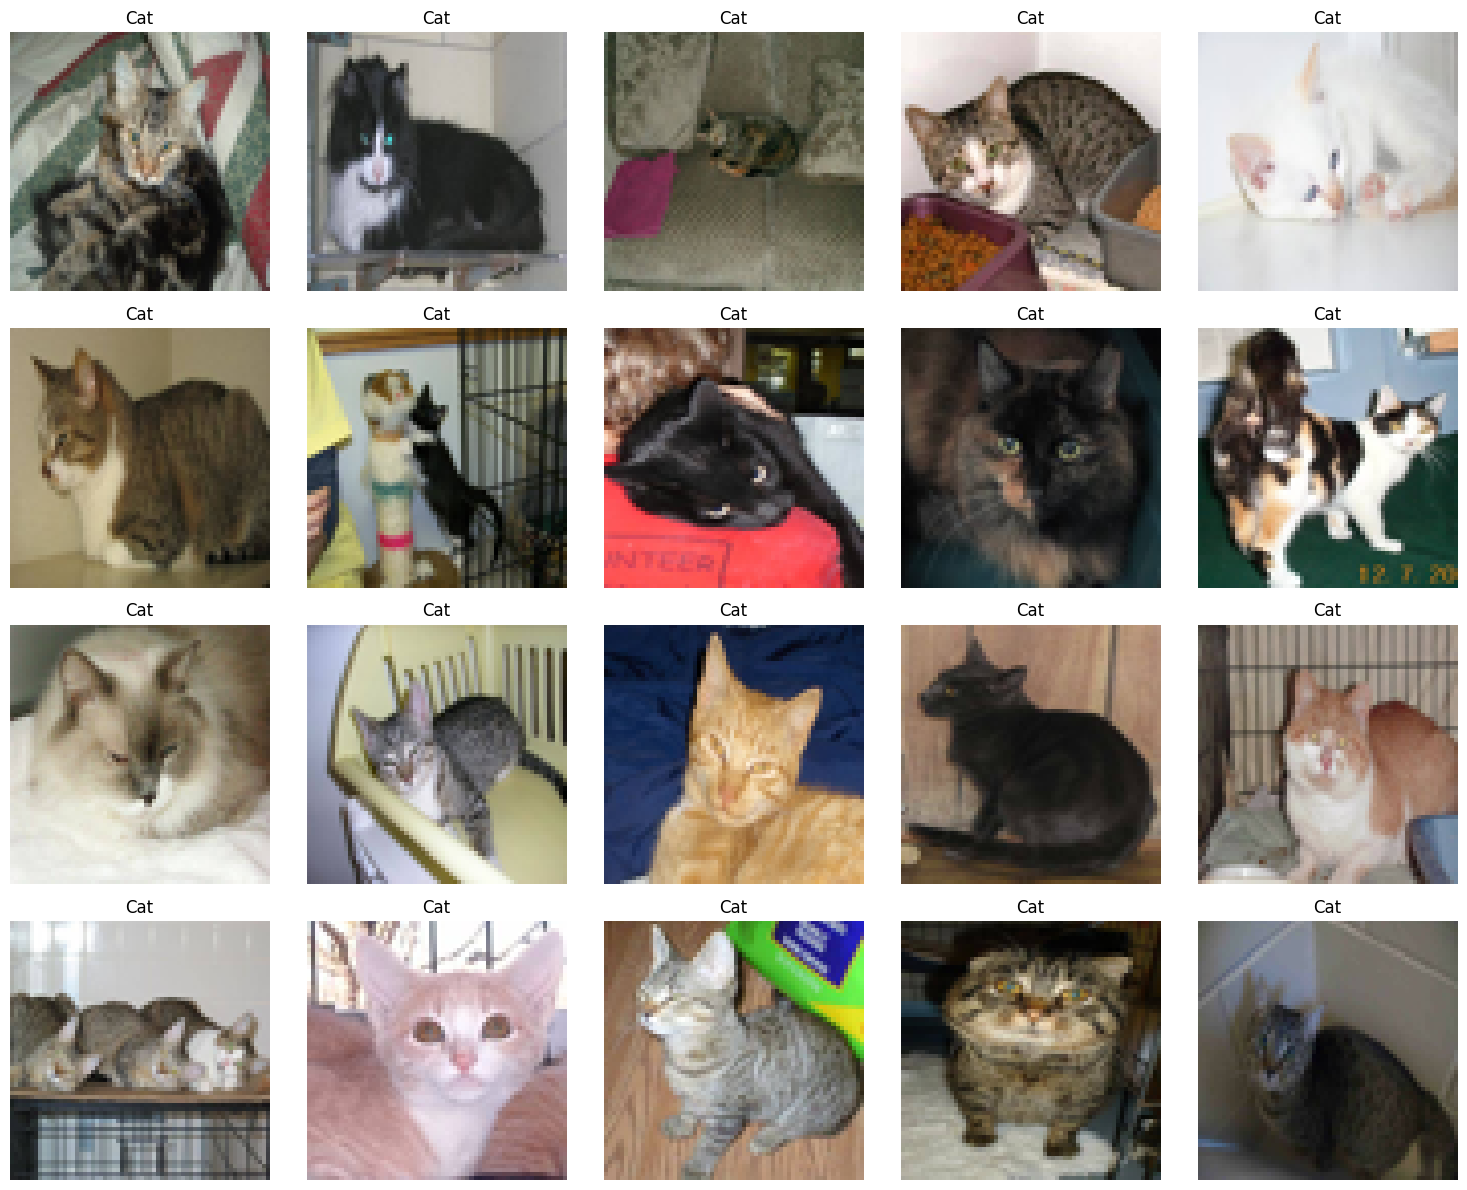

In [7]:
cat_images, cat_labels = load_images(train_dir, sample_count=20, label_filter='cat')
visualize_images(cat_images, cat_labels, sample_count=20)

***Load and visualize dog images***

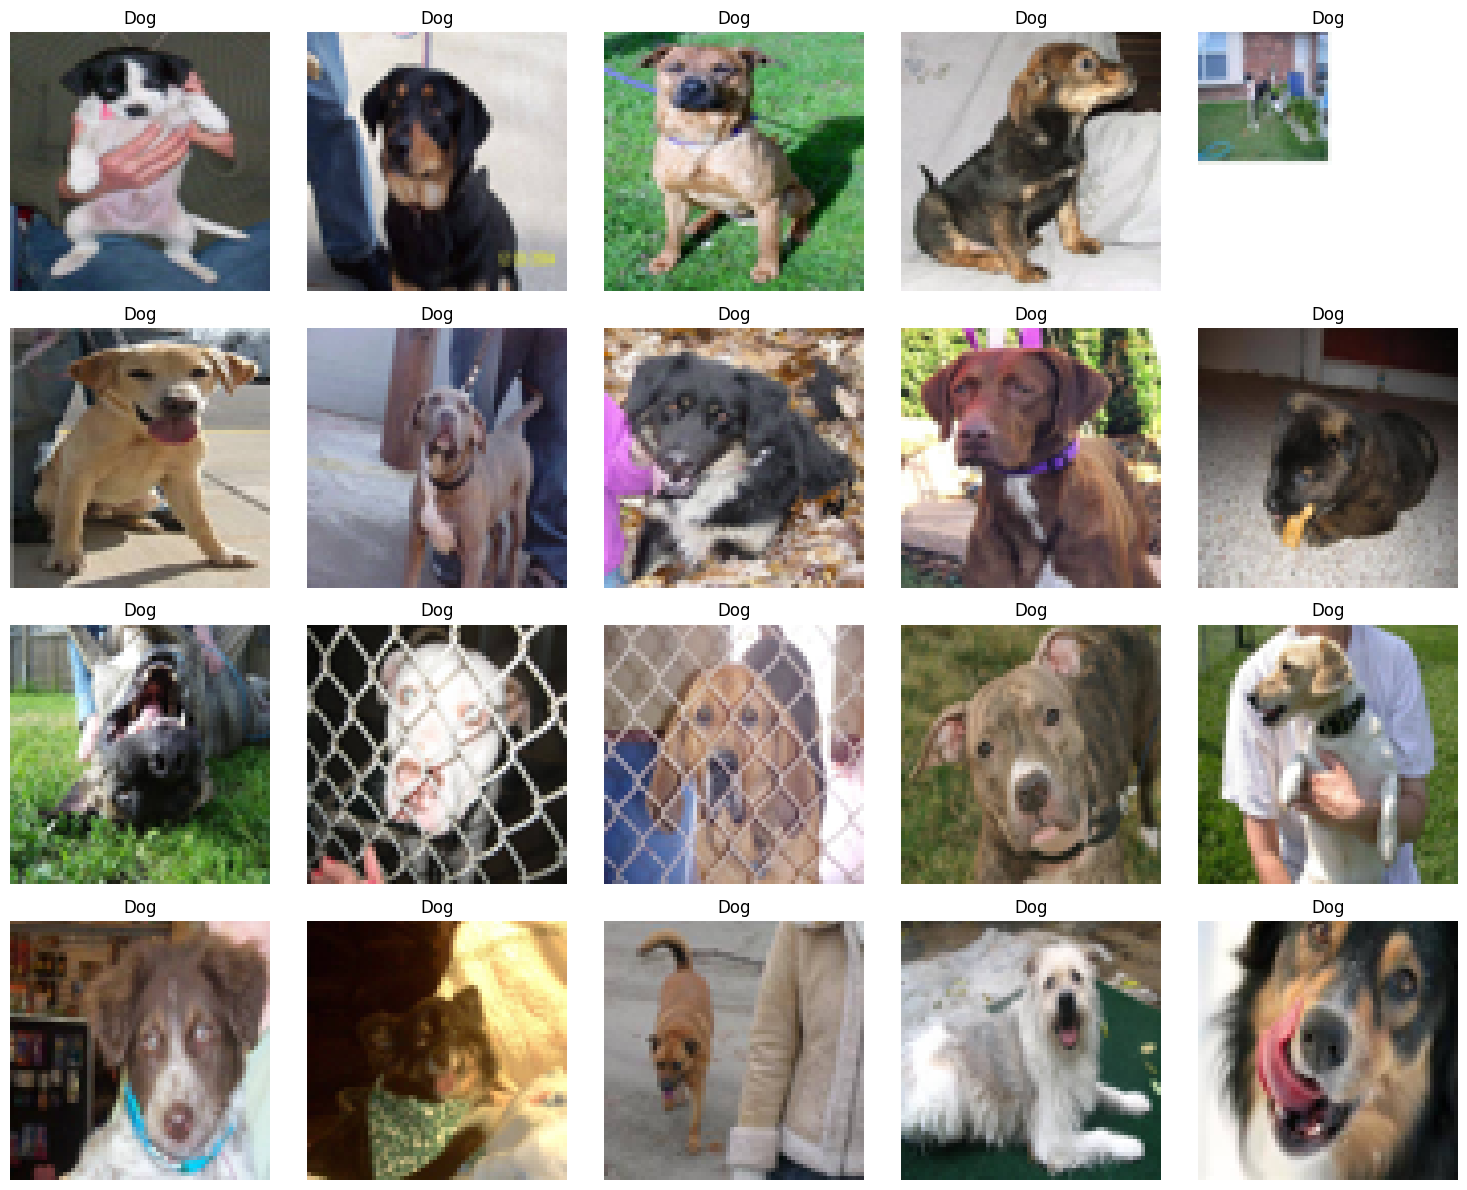

In [8]:
dog_images, dog_labels = load_images(train_dir, sample_count=20, label_filter='dog')
visualize_images(dog_images, dog_labels, sample_count=20)

In [9]:
images, labels = load_images(train_dir, sample_count=10000)
images = images / 255.0

In [10]:
print("Shape of images array:", images.shape)

Shape of images array: (10000, 64, 64, 3)


In [11]:
print("Shape of the first image:", images[0].shape)

Shape of the first image: (64, 64, 3)


In [12]:
print(images[:2])
print(labels[:2])

[[[[0.00172241 0.00107651 0.00109189]
   [0.00173779 0.00109189 0.00110727]
   [0.00184544 0.00118416 0.00118416]
   ...
   [0.00352172 0.00304498 0.0005075 ]
   [0.00342945 0.00293733 0.0004306 ]
   [0.00339869 0.00290657 0.00039985]]

  [[0.00175317 0.00110727 0.00112265]
   [0.00175317 0.00110727 0.00112265]
   [0.00186082 0.00119954 0.0012303 ]
   ...
   [0.00350634 0.00304498 0.00049212]
   [0.00349097 0.00299885 0.00049212]
   [0.00347559 0.00298347 0.00047674]]

  [[0.00179931 0.0011534  0.00116878]
   [0.00179931 0.0011534  0.00116878]
   [0.00190696 0.00124567 0.00127643]
   ...
   [0.0035371  0.00306036 0.00052288]
   [0.00347559 0.00298347 0.00049212]
   [0.00350634 0.00299885 0.00049212]]

  ...

  [[0.0020915  0.00201461 0.00204537]
   [0.00202999 0.00193772 0.00190696]
   [0.0020915  0.00189158 0.00172241]
   ...
   [0.00299885 0.0031065  0.00338331]
   [0.0031065  0.00321415 0.00341407]
   [0.00298347 0.00307574 0.00329104]]

  [[0.00284506 0.00279892 0.00287582]
   [0.0

In [13]:
n_samples, img_height, img_width, img_channels = images.shape
images_flat = images.reshape(n_samples, -1)

In [14]:
scaler = StandardScaler()
images_flat_scaled = scaler.fit_transform(images_flat)

In [15]:
perplexity = min(30, n_samples - 1)
tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42)
images_tsne = tsne.fit_transform(images_flat_scaled)

In [16]:
X_train, X_val, y_train, y_val = train_test_split(images_flat_scaled, labels, test_size=0.2, random_state=42)

In [17]:
X_train

array([[-1.01559954, -0.97235758, -0.70097183, ...,  0.44199639,
         0.44038554,  0.12004047],
       [-0.1441444 , -0.12216919, -0.06732434, ...,  0.69262057,
         0.0048049 , -0.53919254],
       [-0.61558734,  0.12280035,  0.81978214, ..., -0.92906533,
        -0.74619619, -0.42199556],
       ...,
       [-0.07271365,  0.00752056,  0.18613465, ..., -0.45730216,
        -0.40073568, -0.12900311],
       [ 1.513049  ,  0.94416879,  0.56632315, ..., -1.75465088,
        -1.69245756, -1.56466612],
       [ 0.8558861 ,  0.91534885,  0.86202531, ..., -0.41307436,
        -1.42209717, -1.03727971]])

In [18]:
X_val

array([[-1.37275329, -1.46229665, -1.33461932, ..., -0.88483753,
        -1.00153656, -0.90543311],
       [-0.72987654, -0.66974815, -0.54608022, ..., -1.84310647,
        -1.78257769, -1.62326461],
       [-0.50129815, -0.59769829, -0.57424233, ..., -0.38358916,
        -0.29559553, -0.29014896],
       ...,
       [ 1.92734735,  0.65596934,  0.20021571, ...,  0.11765921,
        -0.08531523,  0.06144198],
       [-1.68704859, -0.51123845, -0.32078334, ..., -0.89958013,
        -1.04659662, -0.90543311],
       [ 0.4844462 ,  0.38217986,  0.42551259, ..., -0.14770757,
        -0.02523514,  0.04679236]])

In [19]:
y_val

array([1, 1, 1, ..., 1, 0, 1])

In [20]:
unique, counts = np.unique(labels, return_counts=True)
print(f"Class distribution: {dict(zip(unique, counts))}")

Class distribution: {0: 4983, 1: 5017}


In [21]:
def plot_tsne_data(tsne_data, labels, title):
    df_tsne = pd.DataFrame()
    df_tsne['X'] = tsne_data[:, 0]
    df_tsne['Y'] = tsne_data[:, 1]
    df_tsne['Label'] = labels
    df_tsne['Label'] = df_tsne['Label'].map({0: 'Cat', 1: 'Dog'})
    
    fig = px.scatter(df_tsne, x='X', y='Y', color='Label', title=title)
    fig.show()

plot_tsne_data(images_tsne, labels, 't-SNE visualization of Cats vs Dogs')

/opt/conda/lib/python3.10/site-packages/plotly/express/_core.py:2065: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  sf: grouped.get_group(s if len(s) > 1 else s[0])


In [22]:
svm = SVC(kernel='linear')
svm.fit(X_train, y_train)

SVC(kernel='linear')

In [23]:
y_val_pred = svm.predict(X_val)

In [24]:
y_val_pred

array([1, 0, 0, ..., 1, 0, 0])

In [25]:
val_accuracy = accuracy_score(y_val, y_val_pred)
val_class_report = classification_report(y_val, y_val_pred, target_names=['Cat', 'Dog'])
val_conf_matrix = confusion_matrix(y_val, y_val_pred)

In [26]:
print(f'Validation Accuracy: {val_accuracy:.4f}')

Validation Accuracy: 0.5490


In [27]:
print('Validation Classification Report:')
print(val_class_report)

Validation Classification Report:
              precision    recall  f1-score   support

         Cat       0.55      0.58      0.56      1001
         Dog       0.55      0.52      0.53       999

    accuracy                           0.55      2000
   macro avg       0.55      0.55      0.55      2000
weighted avg       0.55      0.55      0.55      2000



Validation Confusion Matrix:
[[580 421]
 [481 518]]


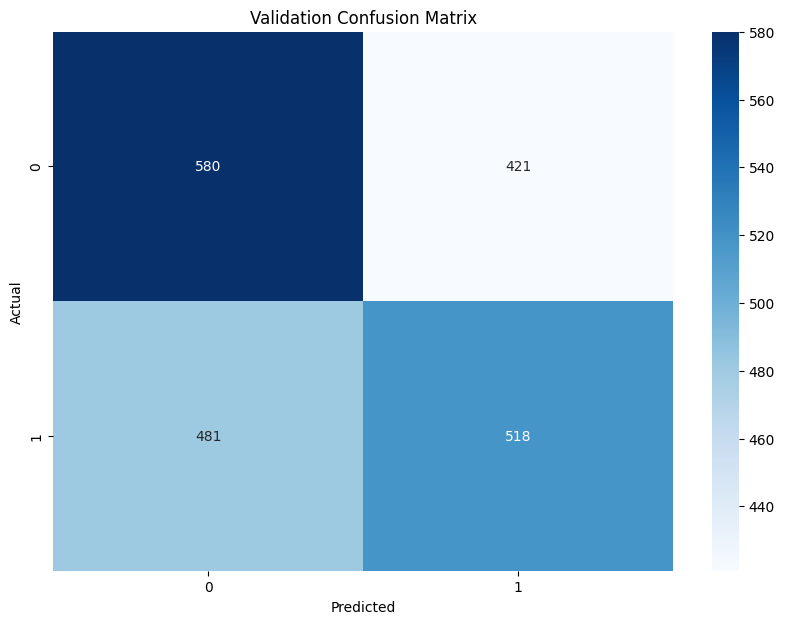

In [28]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
print('Validation Confusion Matrix:')
print(val_conf_matrix)
plt.figure(figsize=(10, 7))
sns.heatmap(val_conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Validation Confusion Matrix')
plt.show()

In [29]:
import pickle
with open('/kaggle/working/svm_model.pkl', 'wb') as f:
    pickle.dump(svm, f)
with open('/kaggle/working/scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

In [30]:
test_images, test_labels = load_images(test_dir)
test_images = test_images / 255.0

In [31]:
n_test_samples, test_img_height, test_img_width, test_img_channels = test_images.shape
test_images_flat = test_images.reshape(n_test_samples, -1)
test_images_flat_scaled = scaler.transform(test_images_flat)

In [32]:
test_images_flat_scaled = scaler.transform(test_images_flat)

In [33]:
# Determine a new perplexity value for the test data
test_perplexity = min(30, n_test_samples - 1)

# Create a new t-SNE instance for the test data
test_tsne = TSNE(n_components=2, perplexity=test_perplexity, random_state=42)
test_images_tsne = test_tsne.fit_transform(test_images_flat_scaled)

In [34]:
y_test_pred = svm.predict(test_images_flat_scaled)

In [35]:
y_test_pred

array([1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0])

In [36]:
df_test_tsne = pd.DataFrame()
df_test_tsne['X'] = test_images_tsne[:, 0]
df_test_tsne['Y'] = test_images_tsne[:, 1]
df_test_tsne['Predicted Label'] = y_test_pred
df_test_tsne['Predicted Label'] = df_test_tsne['Predicted Label'].map({0: 'Cat', 1: 'Dog'})

In [37]:
fig = px.scatter(df_test_tsne, x='X', y='Y', color='Predicted Label', title='t-SNE visualization of Test Data Predictions')
fig.show()

/opt/conda/lib/python3.10/site-packages/plotly/express/_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



In [38]:
def plot_test_samples(images, tsne_data, predictions, sample_count=10):
    sample_indices = np.random.choice(range(len(images)), sample_count, replace=False)
    sample_images = images[sample_indices]
    tsne_samples = tsne_data[sample_indices]
    pred_samples = predictions[sample_indices]

    fig = px.scatter(tsne_samples, x=tsne_samples[:, 0], y=tsne_samples[:, 1], color=pred_samples.astype(str),
                     title="Test Data Predictions (t-SNE Space)")
    fig.show()

plot_test_samples(test_images, test_images_tsne, y_test_pred)

/opt/conda/lib/python3.10/site-packages/plotly/express/_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



In [39]:
test_predictions = pd.DataFrame({'Id': np.arange(1, n_test_samples + 1), 'Label': y_test_pred})
test_predictions['Label'] = test_predictions['Label'].map({0: 'Cat', 1: 'Dog'})
test_predictions.to_csv('/kaggle/working/test_predictions.csv', index=False)

In [40]:
def plot_samples(tsne_data, y_true, y_pred, sample_count=10):
    sample_indices = np.random.choice(range(len(tsne_data)), sample_count, replace=False)
    tsne_samples = tsne_data[sample_indices]
    y_true_samples = y_true[sample_indices]
    y_pred_samples = y_pred[sample_indices]

    df_tsne_samples = pd.DataFrame()
    df_tsne_samples['X'] = tsne_samples[:, 0]
    df_tsne_samples['Y'] = tsne_samples[:, 1]
    df_tsne_samples['True Label'] = y_true_samples
    df_tsne_samples['Predicted Label'] = y_pred_samples
    df_tsne_samples['True Label'] = df_tsne_samples['True Label'].map({0: 'Cat', 1: 'Dog'})
    df_tsne_samples['Predicted Label'] = df_tsne_samples['Predicted Label'].map({0: 'Cat', 1: 'Dog'})

    fig = px.scatter(df_tsne_samples, x='X', y='Y', color='True Label', symbol='Predicted Label', title="True vs Predicted Labels (t-SNE Space)")
    fig.show()

# Apply t-SNE to the validation data
val_tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42)
val_images_tsne = val_tsne.fit_transform(X_val)

# Plot true vs predicted labels for the validation set


In [41]:
plot_samples(val_images_tsne, y_val, y_val_pred)